### We want to check how corona cases and deaths relate to the different parameters of state 
#### State population and rural/urban percentage of state data is downloaded from http://statisticstimes.com/demographics/population-of-indian-states.php
#### Rest of the data is downloaded from data.gov.in

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
date_of_data = '21April2020'

In [3]:
folder = './' + date_of_data;

In [4]:
def getCoronaData( folder ):
    corona_cases = folder + '/corona.csv'
    corona_data = pd.read_csv(corona_cases)
    corona_data.rename(columns = {'Total Confirmed cases':'total_cases', 
                                 'Name of State / UT':'state',
                                 'Cured/Discharged/Migrated':'cured',
                                 'Death':'death'}, inplace = True) 
    corona_data['cure %'] = corona_data['cured']/(corona_data['cured'] + corona_data['death'])
    return corona_data[{'state','total_cases','cured','death','cure %'}].set_index('state')

In [5]:
getCoronaData(folder).head()

,death,total_cases,cured,cure %
state,,,,
Andaman and Nicobar Islands,0,16,11,1.000000
Andhra Pradesh,20,722,92,0.821429
Arunachal Pradesh,0,1,0,NaN
Assam,1,35,19,0.950000
Bihar,2,113,42,0.954545


In [8]:
def getStatePopulation( folder ):
    state_population = folder + '/state_population.csv'
    state_population = pd.read_csv(state_population)
    return state_population.set_index('state')

In [9]:
getStatePopulation(folder).head()

,population2018,populationshare%
state,,
Uttar Pradesh,228959599,17.15
Maharashtra,120837347,9.05
Bihar,119461013,8.95
West Bengal,97694960,7.32
Madhya Pradesh,82342793,6.17


In [10]:
def getRuralUrbanPercentage( folder ):
    ruralUrbanPercentage = folder + '/rural_urban_percentage.csv'
    ruralUrbanPercentage = pd.read_csv(ruralUrbanPercentage)
    return ruralUrbanPercentage.set_index('state')

In [11]:
getRuralUrbanPercentage( folder ).head()

,rural%,urban%
state,,
Himachal Pradesh,89.97,10.03
Bihar,88.71,11.29
Assam,85.90,14.10
Odisha,83.31,16.69
Meghalaya,79.93,20.07


In [12]:
def getGDPData( folder ):
    gdp_csv = folder + '/gdp.csv'
    gdp_data = pd.read_csv(gdp_csv)
    gdp_data = gdp_data[ gdp_data['Duration'] == '2014-15'] #2015-16 and 2016-17 data have many missing values. No data after that
    gdp_data = gdp_data.set_index('Items').T
    gdp_data = gdp_data.reset_index()
    gdp_data.rename(columns={'index':'state'}, inplace=True);
    gdp_data = gdp_data.set_index('state')
    gdp_data.drop(['Duration'], axis=0, inplace=True)
    gdp_data.rename(columns = {'GSDP - CURRENT PRICES (` in Crore)':'gsdp',
                               '(% Growth over previous year)':'%growth'}, inplace=True)
    gdp_data['gsdp'] = gdp_data['gsdp'].astype('float')
    gdp_data['%growth'] = gdp_data['%growth'].astype('float')
    return gdp_data

In [13]:
getGDPData(folder).head()

Items,gsdp,%growth
state,,
Andhra Pradesh,526468.0,13.40
Arunachal Pradesh,16761.0,14.79
Assam,198098.0,11.45
Bihar,373920.0,17.92
Chhattisgarh,234982.0,13.69


In [14]:
def getPopStats( folder ):
    state_stats = folder + '/population.csv'
    state_stats = pd.read_csv(state_stats)
    state_stats = state_stats[ state_stats['Area'] == 'Total' ]
    state_stats = state_stats[ state_stats['Survey'] == 'NFHS-4'];
    state_stats.rename(columns = {'India/States/UTs':'state', 
                                 'Population and Household Profile - Sex ratio of the total population (females per 1000 males)':'female sex ratio',
                                 'Population and Household Profile - Households with electricity (%)' : 'electricity %'}, inplace=True)
    return state_stats[{'state','female sex ratio','electricity %'}].set_index('state')

In [15]:
getPopStats(folder).head()

,female sex ratio,electricity %
state,,
India,991.0,88.2
Andhra Pradesh,1020.0,98.8
Assam,993.0,78.2
Bihar,1062.0,58.6
Chattisgarh,1019.0,95.6


In [16]:
sex_ratio = getPopStats(folder)
cure_percentage = getCoronaData(folder)
gdp_data = getGDPData(folder)
state_pop = getStatePopulation(folder)
rural_urban_percentage = getRuralUrbanPercentage(folder)

In [17]:
joined_1 = sex_ratio.join(cure_percentage,on='state',how='left')
joined_2 = joined_1.join(gdp_data,on='state')
joined_3 = joined_2.join(state_pop,on='state')
joined_4 = joined_3.join(rural_urban_percentage,on='state')
joined = joined_4.dropna() #drop na values
joined.head()

,female sex ratio,electricity %,death,total_cases,cured,cure %,gsdp,%growth,population2018,populationshare%,rural%,urban%
state,,,,,,,,,,,,
Andhra Pradesh,1020.0,98.8,20.0,722.0,92.0,0.821429,526468.0,13.40,52883163.0,3.96,70.53,29.47
Assam,993.0,78.2,1.0,35.0,19.0,0.950000,198098.0,11.45,34586234.0,2.59,85.90,14.10
Bihar,1062.0,58.6,2.0,113.0,42.0,0.954545,373920.0,17.92,119461013.0,8.95,88.71,11.29
Gujarat,950.0,96.0,71.0,1939.0,131.0,0.648515,895027.0,10.82,63907200.0,4.79,57.40,42.60
Haryana,876.0,98.8,3.0,254.0,127.0,0.976923,437462.0,9.18,27388008.0,2.05,65.12,34.88


In [19]:
corona_cols = ['cured', 'cure %', 'death', 'total_cases']
other_cols  = ['female sex ratio', 'electricity %', 'gsdp', '%growth', 'populationshare%','rural%', 'urban%' ]
for col in corona_cols:
    for col2 in other_cols:
        try:
            correlation_val = joined[col].corr(joined[col2])
            print('Correlation between %s and %s is %s' % (col, col2, correlation_val))
        except:
            continue

correlation_val = joined['total_cases'].corr(joined['cure %'])
print('Correlation between total cases and cure percentage is %s' % ( correlation_val))

Correlation between cured and female sex ratio is -0.24812356912663044
Correlation between cured and electricity % is 0.21166646467589853
Correlation between cured and gsdp is 0.7875277673342378
Correlation between cured and %growth is -0.1204294986520063
Correlation between cured and populationshare% is 0.3053426598696529
Correlation between cured and rural% is -0.48038945328612687
Correlation between cured and urban% is 0.4803894532861269
Correlation between cure % and female sex ratio is 0.2747963086624302
Correlation between cure % and electricity % is 0.12893519942908227
Correlation between cure % and gsdp is -0.10678991203861349
Correlation between cure % and %growth is -0.11309613609989917
Correlation between cure % and populationshare% is -0.07522607669626506
Correlation between cure % and rural% is -0.08851500831618067
Correlation between cure % and urban% is 0.08851500831618067
Correlation between death and female sex ratio is -0.3419139494843667
Correlation between death and

### We notice high correlation between gsdp ( gross state domestic product ) and total corona cases, total cured corona cases, but not as high between gsdp and total corona deaths. Larger gsdp states may have larger movement of people, which can explain more number of cases than states with smaller gsdp

### We also notice negative correlation ( not as big though ) between female sex ratio ( per 1000 males ) and total corona cases, cured corona cases and total deaths due to corona, which suggests that more the males in society higher the cases. This can be explained assuming that males are supposedly more out at places where the transmission of the virus is high, or in general males are supposedly more out of their homes.

### We also see negative correlation between total corona deaths and growth % of the state, which is interesting!

### Other than that we notice some ( not significant enough ) correlation between cured corona virus cases and % of state that is urban. And as one would expect, there is some correlation between population of the state and total corona virus cases.

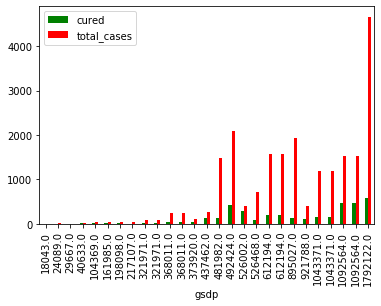

In [20]:
joined.sort_values(by=['gsdp']).plot(kind='bar',x='gsdp',y=['cured','total_cases'],color=['green','red'])
plt.show()

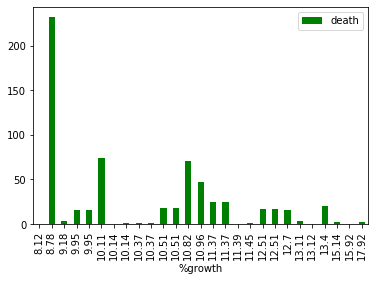

In [21]:
joined.sort_values(by=['%growth']).plot(kind='bar',x='%growth',y=['death'],color=['green','red'])
plt.show()

#### Looking at the above graph, the correlation value seems highly affected by one large number in the data, i.e. number of deaths in maharashtra

### Now let's try building a linear regression model to try to see if relationship between corona cases and other state parameters exist!

In [41]:
from sklearn.utils import shuffle

joined = shuffle(joined)

In [44]:
from sklearn import linear_model

def linear_regression( var, columns ):
    train = joined.iloc[:20, :]
    test = joined.iloc[20:, :]
    
    train_X = train[ columns ]
    test_X = test[ columns ]
    
    train_y = train[var]
    test_y = test[var]
    
    lm = linear_model.LinearRegression()
    model = lm.fit(train_X,train_y)
    print('Linear regression with output as %s : Training accuracy : %3.3f Testing accuracy : %3.3f' % 
          (var,lm.score(train_X,train_y),lm.score(test_X,test_y)) )

In [45]:
columns = ['female sex ratio', 'electricity %', 'gsdp', '%growth', 'populationshare%','rural%', 'urban%']
linear_regression('total_cases', columns)
linear_regression('cured', columns)
linear_regression('cure %', columns)
linear_regression('death', columns)

Linear regression with output as total_cases : Training accuracy : 0.798 Testing accuracy : 0.630
Linear regression with output as cured : Training accuracy : 0.838 Testing accuracy : 0.444
Linear regression with output as cure % : Training accuracy : 0.242 Testing accuracy : -18.324
Linear regression with output as death : Training accuracy : 0.687 Testing accuracy : -2.646


#### One model to look at is the total cured cases - with high training accuracy but low testing accuracy! 
#### Another one to look at is total corona virus cases - we have decent training accuracy and close enough testing accuracy.

In [46]:
columns = ['female sex ratio', 'gsdp', 'populationshare%','rural%']
linear_regression('total_cases', columns)
linear_regression('cured', columns)
linear_regression('cure %', columns)
linear_regression('death', columns)

Linear regression with output as total_cases : Training accuracy : 0.782 Testing accuracy : 0.343
Linear regression with output as cured : Training accuracy : 0.838 Testing accuracy : 0.474
Linear regression with output as cure % : Training accuracy : 0.108 Testing accuracy : -3.673
Linear regression with output as death : Training accuracy : 0.605 Testing accuracy : -1.984


#### nope..no good...one thing we can do here is to cry about it! But now is not the time to cry, now is time to accept it!